# mxnet implement on onnx model

In [15]:
import numpy as np 
import mxnet as mx 
import mxnet.contrib.onnx as onnx_mxnet
import time 
import matplotlib.pyplot as plt 
from PIL import ImageDraw, Image
import PIL
import cv2
import os
import mx_utils as utils
from collections import namedtuple

In [2]:
# 读取图片数据
img_file = '/misc/data/vision/pose/mpii_human_pose/images'
import os
imgs = os.walk(img_file)
imgs = list(imgs)[0][-1]

## Loding the model into mxnet 
to describe the model in mxnet, we need two elements
1. a symbolic graph 
contains the model's network definition, 
2. a binary file 
contains the model weights 

The parameter object is split into argument parameters and auxiliary parameters 

In [ ]:
def get_model(model_path='./bestmodel.onnx'):
    onnx_file = model_path
    sym, arg, aux = onnx_mxnet.import_model(onnx_file)

    # ### Get input data names
    data_names = [graph_input for graph_input in sym.list_inputs() if graph_input not in arg and graph_input not in aux]
    Batch = namedtuple('Batch', ['data'])

    test_image = np.random.rand(1,3, 224, 224).astype('float32')
    mod = mx.mod.Module(symbol=sym, data_names=data_names, context=mx.cpu(), label_names=None)
    mod.bind(for_training=False, data_shapes=[(data_names[0], test_image.shape)], label_shapes=None)
    mod.set_params(arg_params=arg, aux_params=aux, allow_missing=True, allow_extra=True)
    return mod

## Run inference using MXNet's Module API

### Get input data names 

In [5]:
data_names = [graph_input for graph_input in sym.list_inputs() if graph_input not in arg and graph_input not in aux] 
print(data_names)

['Input_0']


### forword compution  and Get output shape
from collections import namedtuple 
Batch = namedtuple('Batch', ['data']) 
mod.forward(Batch([mx.nd.array(test_image)]))

output = mod.get_outputs()[0]
print(type(output))

output.shape

## 预处理图片

In [10]:
## 图片预处理
i = 5
img = os.path.join(img_file, imgs[i]) 
print(img)
# origin_img = plt.imread(img1);plt.imshow(origin_img);plt.show()
f = Image.open(img)
img = f.convert('RGB')
img = np.asarray(img, dtype=np.float32) 
img = img.transpose((2, 0, 1))
image = utils.resize(img, (224, 224))
image = image.astype(np.float32) 

/misc/data/vision/pose/mpii_human_pose/images/071728162.jpg


## 生成模型 and 前向传播

In [16]:

def get_feature(model, image):
    start = time.time()
    processed_image = utils.process_image(image)
    resp, conf, x, y, w, h, e = utils.predict(model, np.expand_dims(processed_image, axis=0))
    resp = np.squeeze(resp, axis=0)
    conf = np.squeeze(conf, axis=0)
    x = np.squeeze(x, axis=0)
    y = np.squeeze(y, axis=0)
    w = np.squeeze(w, axis=0)
    h = np.squeeze(h, axis=0)
    e = np.squeeze(e, axis=0)
    print('inference time {:.5f}'.format(time.time() - start))
    return resp, conf, x, y, w, h, e



# 得到mxnet模型
mod = get_model()
feature_map = get_feature(mod, image)
## 生成kps and joint
humans = utils.get_humans_by_feature(feature_map)

inference time 0.13756
detect instance 0.00149
alchemy time 0.00160
num humans = 2


## 画出图像

draw humans  0.00154


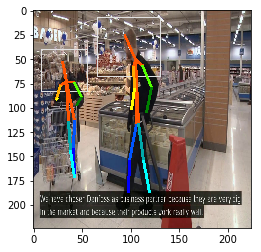

In [18]:
pil_image = Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8))
pil_image = utils.draw_humans(
    pil_image=pil_image,
    humans=humans
)

plt.imshow(pil_image)
plt.show()